### MOOC-HPFEM: Navier-Stokes fluid flow Direct FEM Simulation (DFS)



<p>Incompressible Navier-Stokes as model for low and high Reynolds number flow, such as blood flow and flight: <span class="math display">\begin{array}{rcll} 
R(\hat{u}) &;=&
\begin{cases}
  \partial_t u + (u\cdot \nabla) u + \nabla p - \nu \Delta u = 0\\
  \nabla \cdot u = 0
\end{cases}\\
u &;=& 0, x \in \Gamma \quad (\text{No-slip BC for low Reynolds number})\\
\hat{u} &=& (u, p), \quad r(\hat{u}, \hat{v}) = (R(\hat{u}), \hat{v}) \quad (\text{Weak residual})
\end{array}</span></p>
<dl>
<dt>Space-time cG(1)cG(1) FEM with GLS stabilization. Developed over 20+ years by Johnson, Hoffman, Jansson, etc.</dt>
<dd><p><span class="math display">\begin{aligned}
  &r(\hat{U}, \hat{v}) = (R(\hat{U}), \hat{v}) + (\delta R(\hat{U}), R(\hat{v})) = 0\\
  &\delta = h, \, \forall \hat{v} \in \hat{V}_h, \, \hat{U} \in \hat{V}_h\end{aligned}</span></p>
</dd>

### FEniCS DFS formulation to run and modify yourself

In [20]:
#@title
# Setup system environment and define utility functions and variables
from google.colab import files
#!lsb_release -a
#!python --version
#!uname -a
#try:
#    from dolfin import *; from mshr import *
#except ImportError as e:
#!apt-get install -y -qq software-properties-common python-software-properties module-init-tools
#!add-apt-repository -y ppa:fenics-packages/fenics
#!apt-get update -qq
#!sed -e 's:artful:bionic:' /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list > temp
#!mv temp /etc/apt/sources.list.d/fenics-packages-ubuntu-fenics-artful.list
#!sed -e 's:artful:bionic:' /etc/apt/sources.list > temp
#!mv temp /etc/apt/sources.list
#!apt-get update -qq
#!apt install -y --no-install-recommends fenics python3-dolfin    

try:
  !python3 -c 'from distutils.sysconfig import get_python_lib; print(get_python_lib(prefix="/usr/local"))'
  from dolfin import *; from mshr import *
except ImportError as e:
  import sys
  !python3 -c 'from distutils.sysconfig import get_python_lib; print(get_python_lib(prefix="/usr/local"))'
  sys.path.append('/usr/lib/python3/dist-packages/')
  import sys, os; petsc_dir = '/usr/lib/petsc'; petsc_dir = os.path.join(os.getenv('PETSC_DIR') or petsc_dir, 'lib/python3/dist-packages'); petsc_dir in sys.path or sys.path.append(petsc_dir);
  #!apt-get install python3-dolfin
  !apt-get install -y -qq software-properties-common python-software-properties module-init-tools
  !add-apt-repository -y ppa:fenics-packages/fenics #ppa:fenics-packages/fenics
  #!apt-get update -qq
  !apt install -y fenics #--no-install-recommends
  !python3 -c 'from distutils.sysconfig import get_python_lib; print(get_python_lib(prefix="/usr/local"))'
  from dolfin import *; from mshr import *
    
import matplotlib.pyplot as plt;
from IPython.display import clear_output, display, update_display; import time; import dolfin.common.plotting as fenicsplot 
import time

def plot_compact(u, t, stepcounter, QQ): # Compact plot utility function
    if stepcounter % 5 == 0:
        uEuclidnorm = project(sqrt(inner(u, u)), QQ); ax.cla(); fig = plt.gcf(); fig.set_size_inches(16, 4)
        plt.subplot(1, 2, 1); pp = plot(uEuclidnorm); plt.title("Velocity at t=%f" % (t)) # Plot norm of velocity
        if t == 0.: plt.axis(G); plt.colorbar(pp, shrink=0.5); 
        plt.subplot(1, 2, 2);
        if t == 0.: plot(Q.mesh()); plt.title("Mesh") # Plot mesh
        plt.tight_layout(); dpl = display(pl, display_id="test");


/usr/local/lib/python3/dist-packages


4049


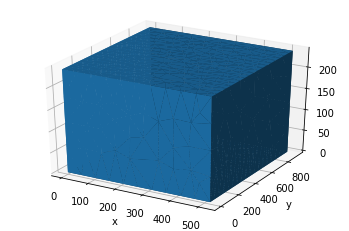

In [27]:
# Define geometry
x_max = 520
y_max = 920
z_max = 240
G = 
box = Box(Point(0,0,0),Point(x_max,y_max,z_max))
building1= Box(Point(200,200,0), Point(240,240,40))
building2 = Box(Point(280,280,0), Point(320,320,40))
geometry = box-building1-building2

# Making Mesh (40 corresponds to the mesh density)
mesh = generate_mesh(geometry, 20)
# mesh = Mesh("testBuild.xml")
print(mesh.num_cells())

plot(mesh)
plt.xlabel('x')
plt.ylabel('y')
plt.show()


In [28]:
# Set up function spaces

# FEM functions
VE = VectorElement("CG", mesh.ufl_cell(), 1)
QE = FiniteElement("CG", mesh.ufl_cell(), 1) 
h = CellDiameter(mesh)

# Make a mixed space
WE = VE * QE
W = FunctionSpace(mesh, WE)
V = FunctionSpace(mesh, VE)
Q = FunctionSpace(mesh, QE) 

(v, q) = TestFunctions(W)
w = Function(W)
(u, p) = (as_vector((w[0], w[1], w[2])), w[3])
u0 = Function(V)

In [29]:
# atmospheric boundary layer inlet profile

u_h = 5 # wind speed at reference height
h_ref = 1.5 # reference height
z_0 = 0.5 # aerodynamic roughness length
uin = Expression(('0','(0.4 * u_h / std::log((h_ref+z_0)/x[2]))/0.4 * std::log(x[2]+z_0/z_0)','0'), u_h = u_h, h_ref = h_ref, z_0 = z_0, element = V.ufl_element()) # Inflow velocity



In [30]:
# Mark regions for boundary conditions
eps = 1e-5
om = Expression("x[1] > y_max - eps ? 1. : 0.", y_max = y_max, eps=eps, element = Q.ufl_element()) 
im = Expression("x[1] < eps ? 1. : 0.", eps=eps, element = Q.ufl_element())
nm = Expression("x[1] > eps && x[1] < y_max - eps ? 1. : 0.", y_max = y_max, eps=eps, element = Q.ufl_element())

Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.
Calling FFC just-in-time (JIT) compiler, this may take some time.


/usr/lib/petsc/lib/python3/dist-packages/dolfin/common/plotting.py:279: UserWarning: Requested projection is different from current axis projection, creating new axis with requested projection.
  ax = plt.gca(projection='3d')


NameError: ignored

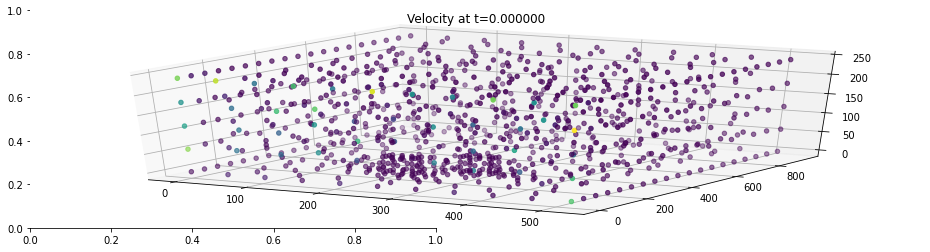

In [31]:
# Copyright (c) 2017-2018 Johan Jansson, Måns Andersson, Cem Degirmenci, David Kamensky, FEniCS community contributions 
from fenics import *

# Plotting setup
pl, ax = plt.subplots()
display(pl)
clear_output() 

k = 0.1 # Timestep
nu = 1.46e-5 # Viscosity
d = .2*h**(3./2.) # stabilization parameters

t, T = 0., 10. # Time interval
gamma = 10*1./h # Penalty parameter

theta = 0.5 # 0.5 - Midpoint rule, 1.0 - Implicit Euler, 0.0 - Explicit Euler
stepcounter = 0

while t < T: # Time-stepping loop
    um = theta*u + (1.0-theta)*u0 # Weak residual of stabilized FEM for Navier-Stokes eq.

    r = ((inner((u - u0)/k + grad(p) + grad(um)*um, v) + nu*inner(grad(um), grad(v)) + div(um)*q)*dx +
        gamma*(om*p*q + im*inner(u - uin, v) + nm*inner(u, v))*ds + # Weak boundary conditions
        d*(inner(grad(p) + grad(um)*um, grad(q) + grad(um)*v) + inner(div(um), div(v)))*dx) # Stabilization
        
    solve(r==0, w)  # Solve the Navier-Stokes PDE (one timestep)
    plot_compact(u, t, stepcounter, Q) # Plot all quantities (see implementation above)
    t += k; stepcounter += 1; u0 = project(u, V); # Shift to next timestep